<a href="https://colab.research.google.com/github/operixon/mlsg-kaggle/blob/master/mouseprobe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importy

In [ ]:
import pandas as pd
import glob
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt  # To visualize
from sklearn.linear_model import LinearRegression


# Zmienne globalne

# Dane

## Pobranie danych z git

In [ ]:
%%bash
rm -rf mouseml
git clone https://github.com/operixon/mouseml.git


Cloning into 'mouseml'...


In [ ]:
!ls mouseml/test1/local/clean

t1-artur-local-session-1.txt  t1-konrad-local-session-1-touhpad.txt
t1-artur-local-session-2.txt  t1-konrad-local-session-2-mouse.txt


## Czytanie danych 

- czytanie plików w katalogach (t x y)
- generowanie kolumn z cechami dx, dy, dt ...

- output : **mpd** ( dataframe zawierający oznaczone sesje )

In [ ]:
#TODO : przewijanie indexu do 0. Niektóre serie zaczynaja się np od 5 minuty
def preprocess(df):
  d = df#.copy()
  # Time indexes
  d['t_int'] = d['t'] # jak zrobie kol t indeksem to zniknie wiec robie sobie zapasowa
  d['t'] = pd.to_timedelta(d['t'],unit='ms')
  d['t_ms'] = d['t'] # jak zrobie kol t indeksem to zniknie wiec robie sobie zapasowa
  d['dt'] = d.t.diff()
  d.set_index(['t'],inplace=True)
  d = d.sort_index()

  # Features
  window_size='5s'
  d['dx'] = d.x.diff()
  d['dy'] = d.y.diff()
  d['std_dx'] = d.dx.rolling(window_size).std()
  d['std_dy'] = d.dy.rolling(window_size).std()
  
  d['count_1s'] = d.dx.rolling('1s').count()
  d['count_5s'] = d.dy.rolling('5s').count()
  d['count_10s'] = d.dy.rolling('10s').count()
  d['count_25s'] = d.dy.rolling('25s').count()
  d['count_60s'] = d.dy.rolling('60s').count()

  d['mean_dx'] = d.dx.rolling(window_size).mean()
  d['mean_dy'] = d.dy.rolling(window_size).mean()
  d['median_dx'] = d.dx.rolling(window_size).median()
  d['median_dy'] = d.dy.rolling(window_size).median()
  d['cov_dx'] = d.dx.rolling(window_size).cov()
  d['cov_dy'] = d.dy.rolling(window_size).cov()
  d['corr_dx'] = d.dx.rolling(window_size).corr()
  d['corr_dy'] = d.dy.rolling(window_size).corr()
  d['skew_dx'] = d.dx.rolling(window_size).skew()
  d['skew_dy'] = d.dy.rolling(window_size).skew()
  d['kurt_dx'] = d.dx.rolling(window_size).kurt()
  d['kurt_dy'] = d.dy.rolling(window_size).kurt()
  d['ql_dx'] = d.dx.rolling(window_size).quantile(.2, interpolation='midpoint')
  d['ql_dy'] = d.dy.rolling(window_size).quantile(.2, interpolation='midpoint')
  d['qh_dx'] = d.dx.rolling(window_size).quantile(.8, interpolation='midpoint')
  d['qh_dy'] = d.dy.rolling(window_size).quantile(.8, interpolation='midpoint')

  
  return d

def readFromFile(f):
  print(f)
  d = pd.read_csv(f, skiprows=3, header=None)
  d.columns =  ["t","x","y"]
  d['file'] = f
  return preprocess(d)

def readFromDir(dir,session) :
  localData = pd.concat(map(readFromFile, glob.glob(os.path.join(dir, "*.txt"))))
  localData['session'] = session
  return localData

def loadData() :
  d = pd.concat([readFromDir('mouseml/test1/local/clean/','local'),
                 readFromDir('mouseml/test1/remote/clean/','remote')])
  # Workaround
  d['sid'] = ""
  d.loc[d.file == 'mouseml/test1/local/clean/t1-artur-local-session-2.txt','sid'] = "a2"
  d.loc[d.file == 'mouseml/test1/local/clean/t1-konrad-local-session-2-mouse.txt','sid']= "k2" 
  d.loc[d.file == 'mouseml/test1/local/clean/t1-artur-local-session-1.txt','sid']= "a1"
  d.loc[d.file == 'mouseml/test1/local/clean/t1-konrad-local-session-1-touhpad.txt','sid']= "k1"
  d.loc[d.file == 'mouseml/test1/remote/clean/t1-artur-remote-msteams-session2.txt','sid']= "a2"
  d.loc[d.file == 'mouseml/test1/remote/clean/t1-artur-remote-msteams-session1.txt','sid']="a1"
  d.loc[d.file == 'mouseml/test1/remote/clean/t1-konrad-remote-msteams-session2.txt','sid']="k2"
  d.loc[d.file == 'mouseml/test1/remote/clean/t1-konrad-remote-msteams-session1.txt','sid']="k1"
  return d


mdp = loadData()



mouseml/test1/local/clean/t1-artur-local-session-2.txt
mouseml/test1/local/clean/t1-konrad-local-session-2-mouse.txt
mouseml/test1/local/clean/t1-artur-local-session-1.txt
mouseml/test1/local/clean/t1-konrad-local-session-1-touhpad.txt
mouseml/test1/remote/clean/t1-artur-remote-msteams-session2.txt
mouseml/test1/remote/clean/t1-artur-remote-msteams-session1.txt
mouseml/test1/remote/clean/t1-konrad-remote-msteams-session2.txt
mouseml/test1/remote/clean/t1-konrad-remote-msteams-session1.txt


# Podstawowe statystyki

In [ ]:
mdp

,x,y,file,dt,dx,dy,std_dx,std_dy,count_dx,count_dy,mean_dx,mean_dy,median_dx,median_dy,cov_dx,cov_dy,corr_dx,corr_dy,skew_dx,skew_dy,kurt_dx,kurt_dy,ql_dx,ql_dy,qh_dx,qh_dy,session,sid
t,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0 days 00:00:02.284000,417,489,mouseml/test1/local/clean/t1-artur-local-sessi...,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,local,a2
0 days 00:00:02.299000,431,463,mouseml/test1/local/clean/t1-artur-local-sessi...,0 days 00:00:00.015000,14.0,-26.0,NaN,NaN,1.0,1.0,14.000000,-26.000000,14.0,-26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,-26.0,14.0,-26.0,local,a2
0 days 00:00:02.331000,452,433,mouseml/test1/local/clean/t1-artur-local-sessi...,0 days 00:00:00.032000,21.0,-30.0,4.949747,2.828427,2.0,2.0,17.500000,-28.000000,17.5,-28.0,24.500000,8.000000,1.0,1.0,NaN,NaN,NaN,NaN,17.5,-28.0,17.5,-28.0,local,a2
0 days 00:00:02.350000,458,428,mouseml/test1/local/clean/t1-artur-local-sessi...,0 days 00:00:00.019000,6.0,-5.0,7.505553,13.428825,3.0,3.0,13.666667,-20.333333,14.0,-26.0,56.333333,180.333333,1.0,1.0,-0.199458,1.560772,NaN,NaN,10.0,-28.0,17.5,-15.5,local,a2
0 days 00:00:02.365000,471,420,mouseml/test1/local/clean/t1-artur-local-sessi...,0 days 00:00:00.015000,13.0,-8.0,6.137318,12.579746,4.0,4.0,13.500000,-17.250000,13.5,-17.0,37.666667,158.250000,1.0,1.0,0.000000,-0.037800,1.367844,-5.230500,9.5,-28.0,17.5,-6.5,local,a2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0 days 00:06:03.513000,922,531,mouseml/test1/remote/clean/t1-konrad-remote-ms...,0 days 00:00:00.047000,29.0,-6.0,10.175356,11.681052,12.0,12.0,16.083333,5.083333,21.0,5.0,103.537879,136.446970,1.0,1.0,-0.585430,0.286085,-1.194346,-0.336706,7.5,-4.0,24.0,13.5,remote,k1
0 days 00:06:03.533000,963,523,mouseml/test1/remote/clean/t1-konrad-remote-ms...,0 days 00:00:00.020000,41.0,-8.0,11.944315,11.757703,13.0,13.0,18.000000,4.076923,21.0,4.0,142.666667,138.243590,1.0,1.0,-0.006935,0.421839,-0.258467,-0.435489,7.5,-5.0,24.0,13.5,remote,k1
0 days 00:06:03.574000,1010,519,mouseml/test1/remote/clean/t1-konrad-remote-ms...,0 days 00:00:00.041000,47.0,-4.0,13.847878,11.500836,14.0,14.0,20.071429,3.500000,22.0,1.5,191.763736,132.269231,1.0,1.0,0.292422,0.555379,-0.137831,-0.297697,7.5,-5.0,26.5,13.5,remote,k1


In [ ]:
mdp.info() 


<class 'pandas.core.frame.DataFrame'>
TimedeltaIndex: 39609 entries, 0 days 00:00:02.284000 to 0 days 00:06:03.644000
Data columns (total 32 columns):
 #   Column     Non-Null Count  Dtype          
---  ------     --------------  -----          
 0   x          39609 non-null  int64          
 1   y          39609 non-null  int64          
 2   file       39609 non-null  object         
 3   t_ms       39609 non-null  timedelta64[ns]
 4   dt         39601 non-null  timedelta64[ns]
 5   dx         39601 non-null  float64        
 6   dy         39601 non-null  float64        
 7   std_dx     39588 non-null  float64        
 8   std_dy     39588 non-null  float64        
 9   count_1s   39601 non-null  float64        
 10  count_5s   39601 non-null  float64        
 11  count_10s  39601 non-null  float64        
 12  count_25s  39601 non-null  float64        
 13  count_60s  39601 non-null  float64        
 14  mean_dx    39601 non-null  float64        
 15  mean_dy    39601 non-null  f

In [ ]:
mdp.describe()

,x,y,dt,dx,dy,std_dx,std_dy,count_dx,count_dy,mean_dx,mean_dy,median_dx,median_dy,cov_dx,cov_dy,corr_dx,corr_dy,skew_dx,skew_dy,kurt_dx,kurt_dy,ql_dx,ql_dy,qh_dx,qh_dy
count,39609.000000,39609.000000,39601,39601.000000,39601.000000,39588.000000,39588.000000,39601.000000,39601.000000,39601.000000,39601.000000,39601.000000,39601.000000,39588.000000,39588.000000,39587.000000,39584.000000,39573.000000,39568.000000,39557.000000,39553.000000,39601.000000,39601.000000,39601.000000,39601.000000
mean,681.954657,385.140726,0 days 00:00:00.066537259,0.047145,0.005000,16.752011,9.725611,128.579682,128.579682,-0.153936,0.014859,-0.083495,0.040933,765.326478,224.856731,0.999975,0.999924,-0.038129,-0.075663,6.894314,5.513251,-6.085629,-3.726307,5.873968,3.870205
std,219.023675,144.657552,0 days 00:00:00.226050747,27.336046,15.133599,22.016104,11.413699,98.871020,98.871020,6.065829,2.741132,3.086340,1.617207,2571.841134,732.895278,0.005026,0.008705,2.061500,1.729453,7.024881,6.244582,9.898685,4.566744,8.853146,4.390209
min,0.000000,1.000000,0 days 00:00:00,-742.000000,-389.000000,0.000000,0.000000,1.000000,1.000000,-138.666667,-39.000000,-123.500000,-39.000000,0.000000,0.000000,0.000000,0.000000,-7.082503,-6.925261,-3.333333,-5.230500,-294.000000,-55.000000,-56.000000,-39.000000
25%,523.000000,283.000000,0 days 00:00:00.010000,-2.000000,-2.000000,4.627133,2.916478,55.000000,55.000000,-1.891304,-1.053333,-1.000000,0.000000,21.410359,8.505841,1.000000,1.000000,-1.495904,-1.184402,2.227075,1.531703,-6.500000,-4.500000,1.000000,1.000000
50%,652.000000,390.000000,0 days 00:00:00.016000,0.000000,0.000000,7.905479,5.569794,91.000000,91.000000,0.036398,-0.011730,0.000000,0.000000,62.496594,31.022605,1.000000,1.000000,0.064894,0.037735,4.812478,3.508793,-3.000000,-2.000000,3.000000,3.000000
75%,840.000000,500.000000,0 days 00:00:00.043000,2.000000,2.000000,19.624994,12.278579,197.000000,197.000000,1.721519,1.100000,0.000000,1.000000,385.140406,150.763492,1.000000,1.000000,1.354542,0.990486,9.250385,7.485668,-1.000000,-1.000000,6.000000,5.000000
max,1609.000000,706.000000,0 days 00:00:14.955000,682.000000,395.000000,260.071358,115.018551,544.000000,544.000000,58.928571,23.250000,37.000000,25.500000,67637.111111,13229.267007,1.000000,1.000000,7.426941,6.309344,68.663315,56.768695,35.500000,17.000000,113.500000,55.500000


In [ ]:
mdp.groupby('session').describe()

x                                 ... qh_dy                
           count        mean         std    min  ...   25%  50%  75%   max
session                                          ...                      
local    25467.0  674.892213  210.910020    0.0  ...   1.0  2.0  4.0  41.5
remote   14142.0  694.672748  232.390154  179.0  ...   2.0  4.0  7.5  55.5

[2 rows x 200 columns]

In [ ]:
mdp.groupby(['file']).describe()

x  ... qh_dy
                                                      count  ...   max
file                                                         ...      
mouseml/test1/local/clean/t1-artur-local-sessio...   3125.0  ...  41.5
mouseml/test1/local/clean/t1-artur-local-sessio...   3552.0  ...  26.0
mouseml/test1/local/clean/t1-konrad-local-sessi...   4931.0  ...  10.0
mouseml/test1/local/clean/t1-konrad-local-sessi...  13859.0  ...  17.0
mouseml/test1/remote/clean/t1-artur-remote-mste...   2906.0  ...  55.5
mouseml/test1/remote/clean/t1-artur-remote-mste...   2111.0  ...  25.5
mouseml/test1/remote/clean/t1-konrad-remote-mst...   4625.0  ...  38.0
mouseml/test1/remote/clean/t1-konrad-remote-mst...   4500.0  ...  24.0

[8 rows x 200 columns]

# EDA

## Porównanie cech dla sesji local i remote

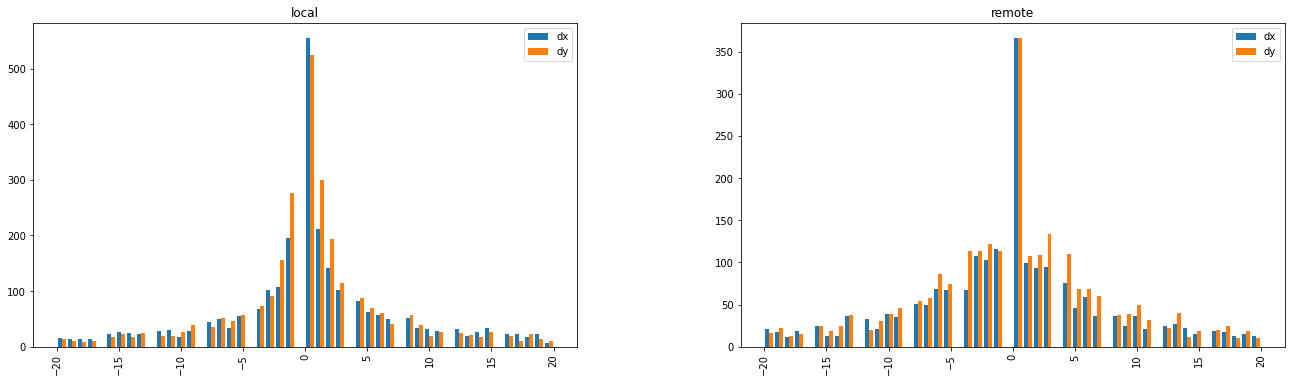

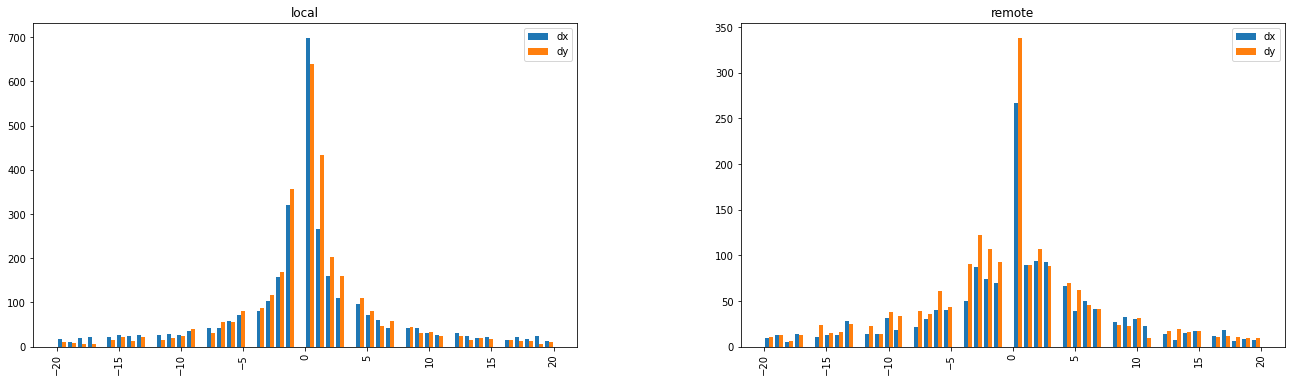

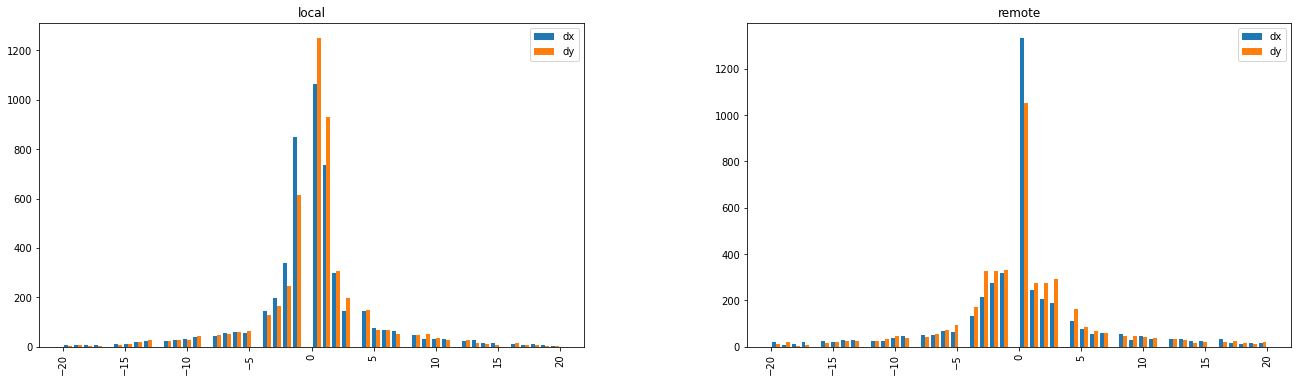

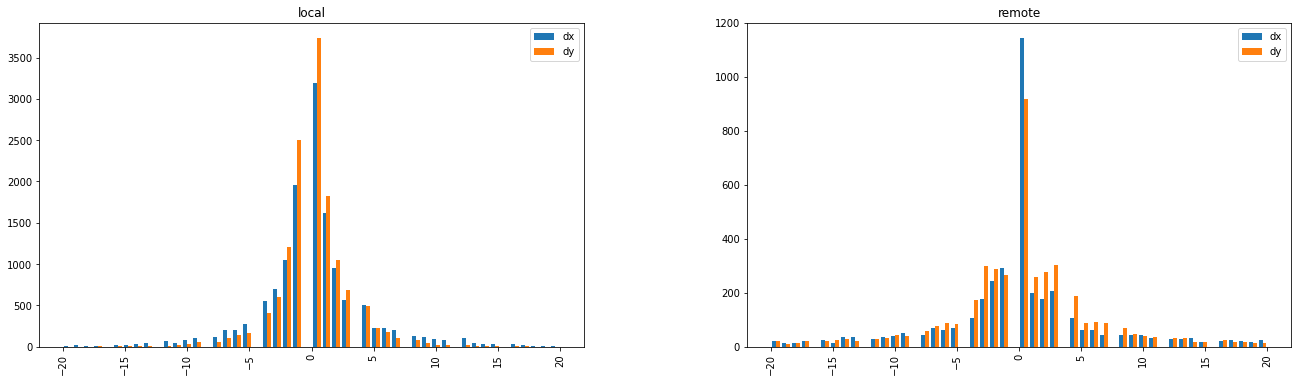

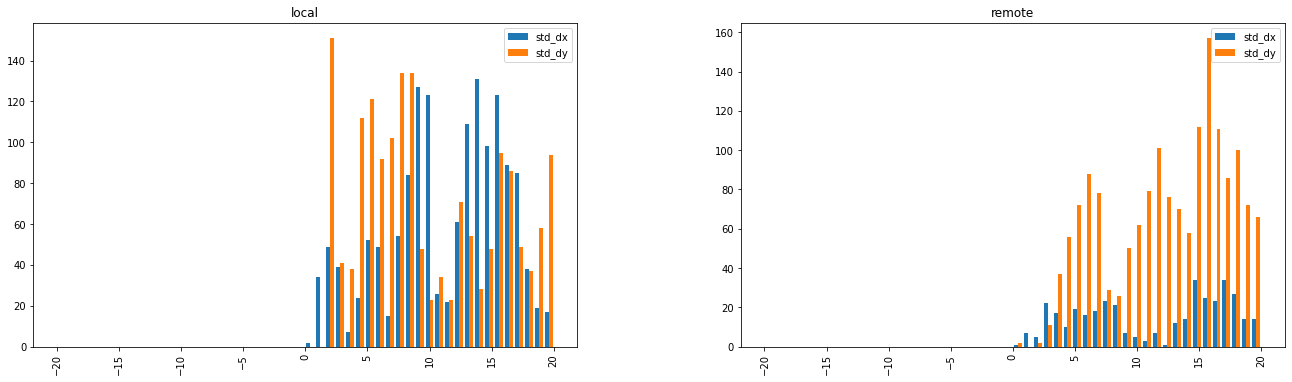

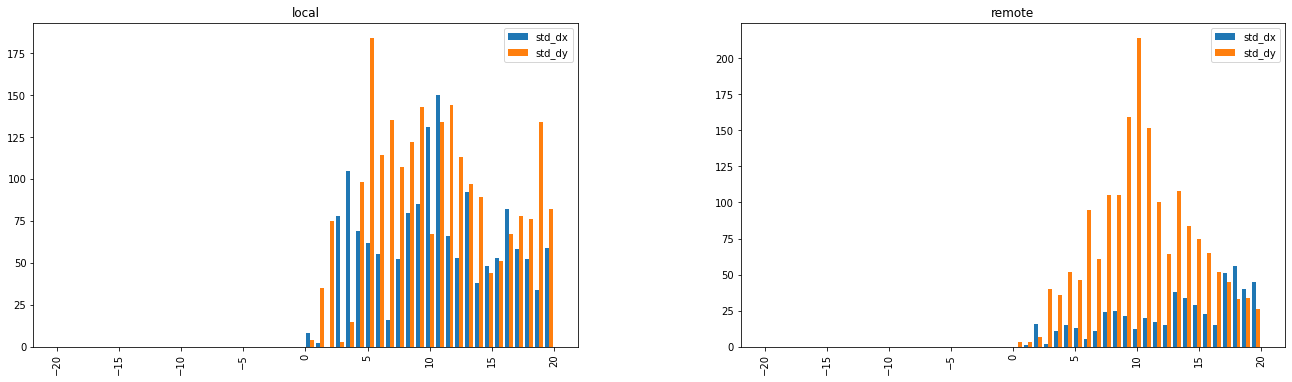

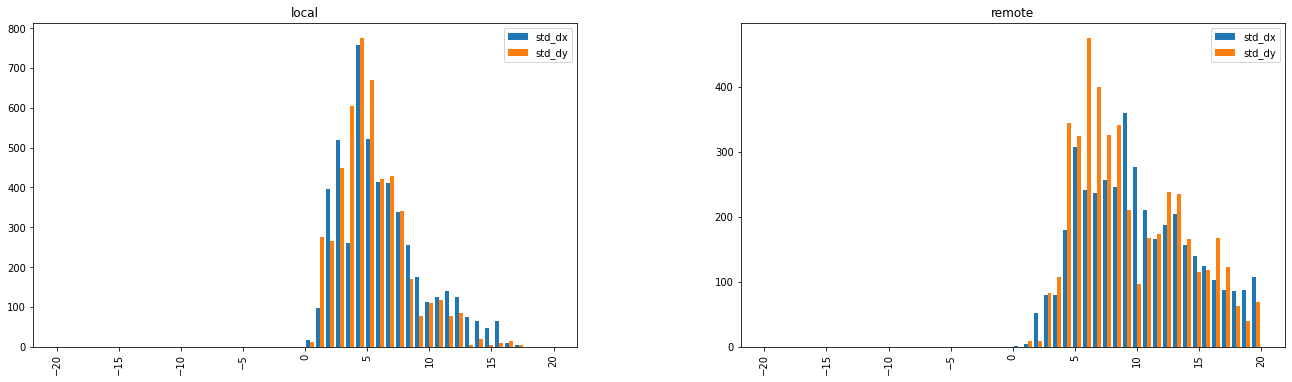

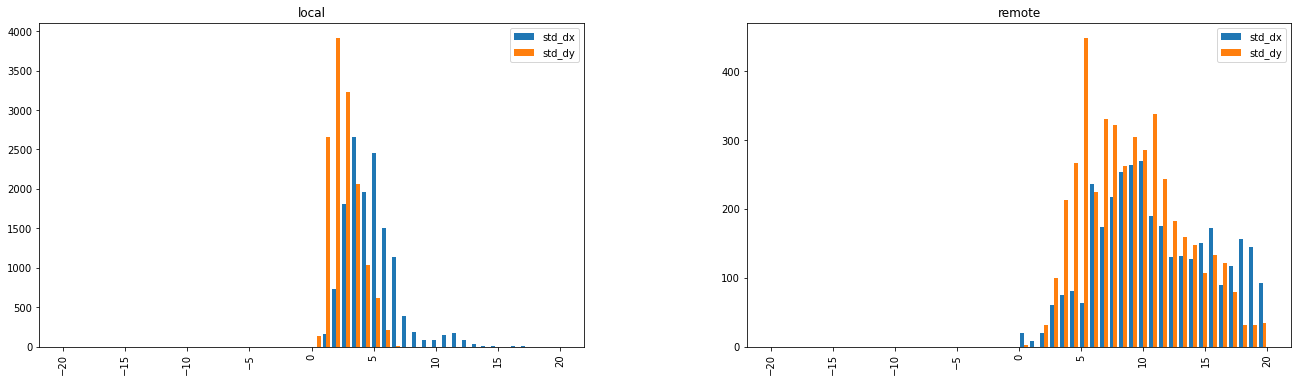

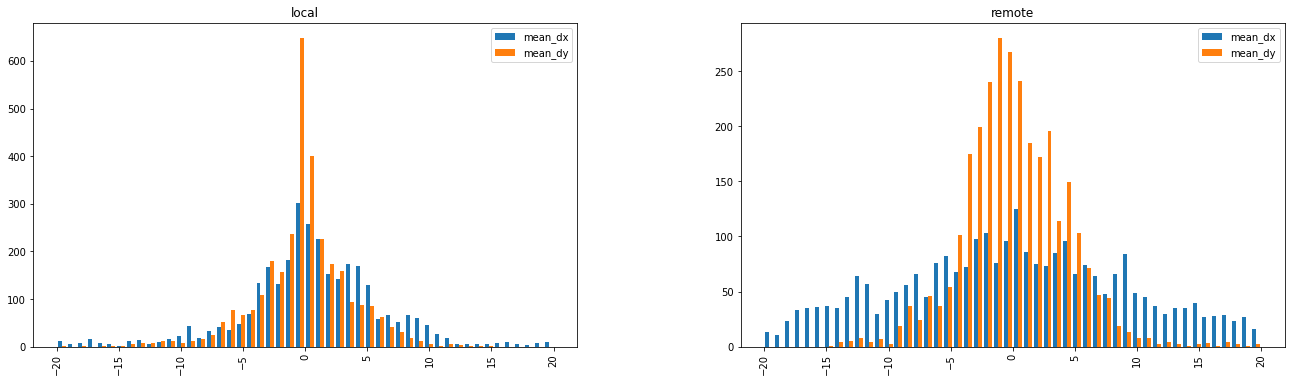

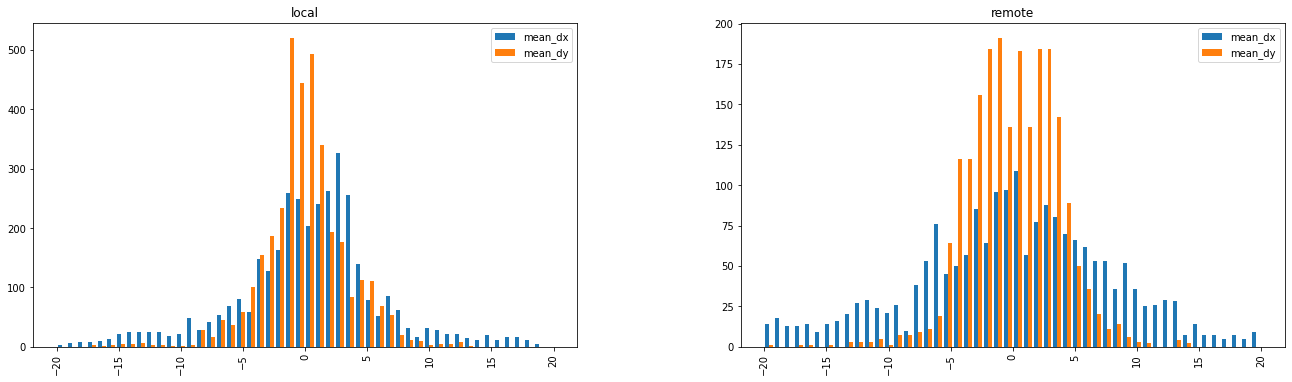

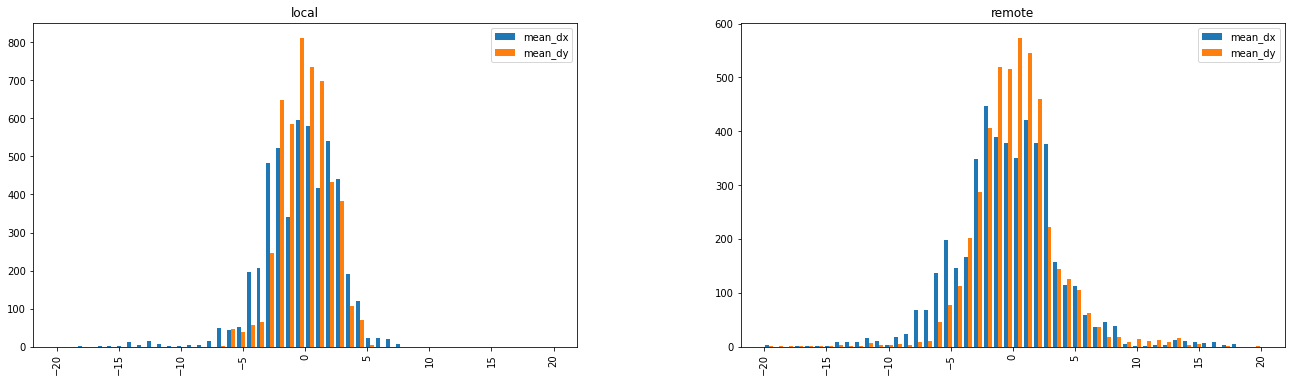

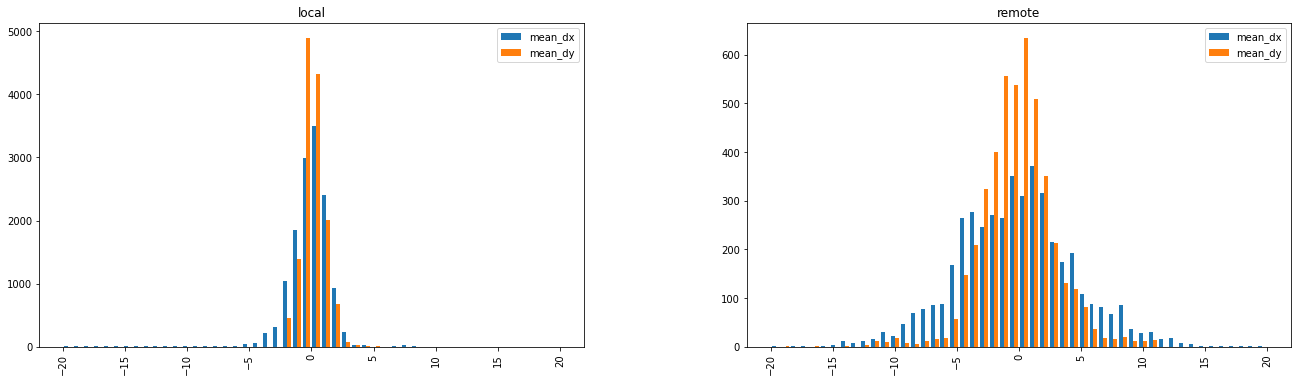

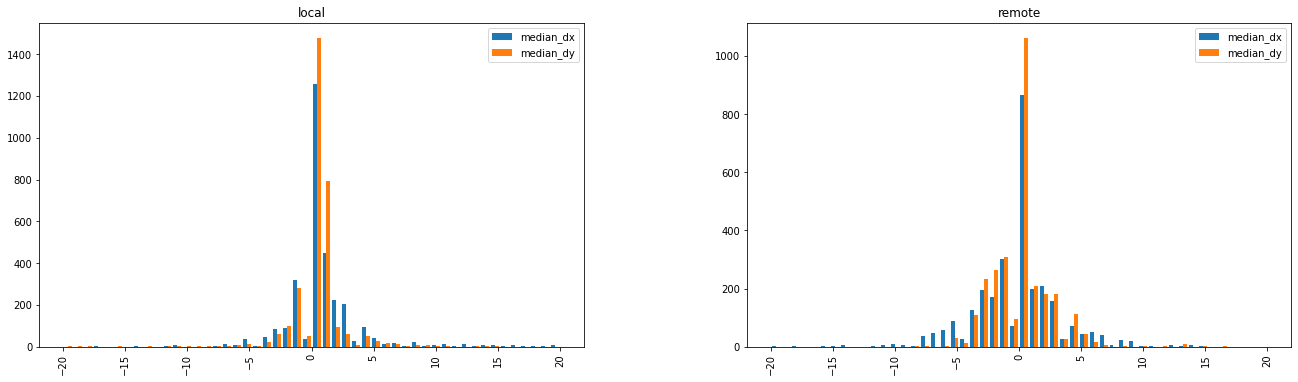

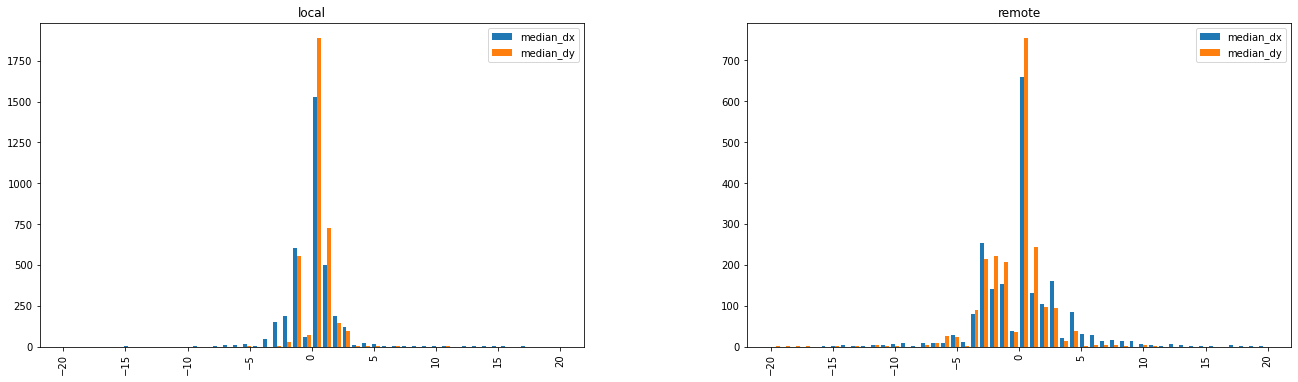

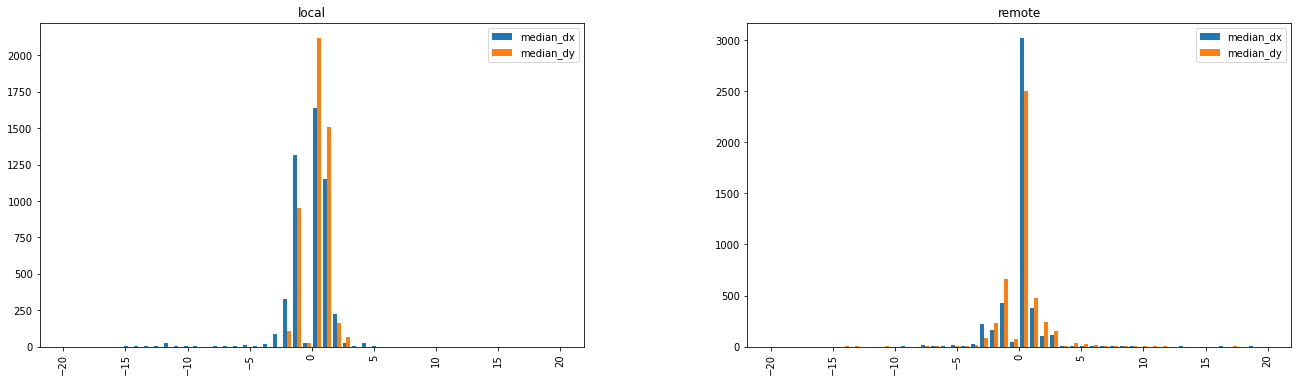

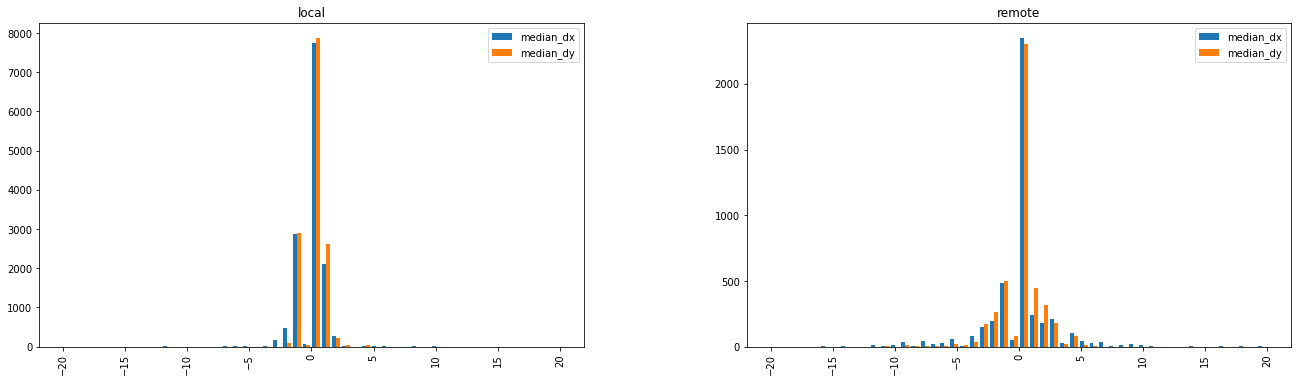

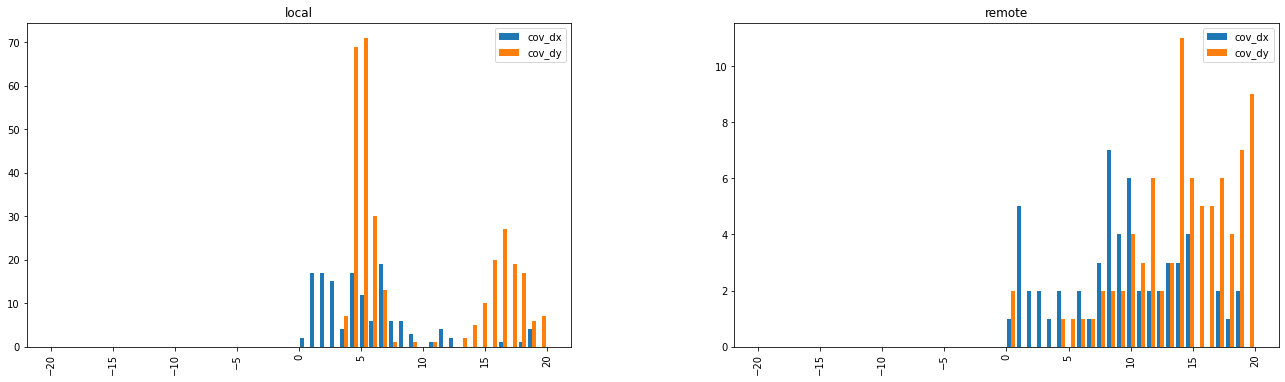

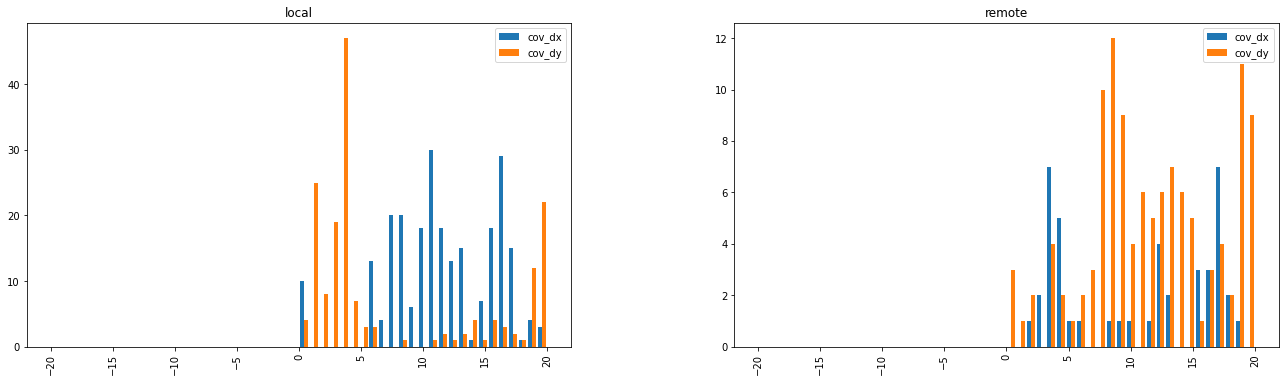

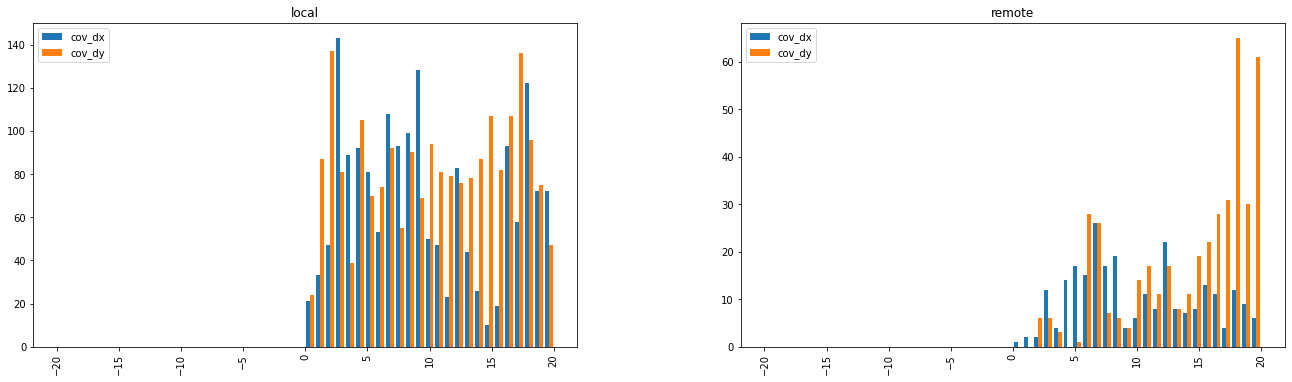

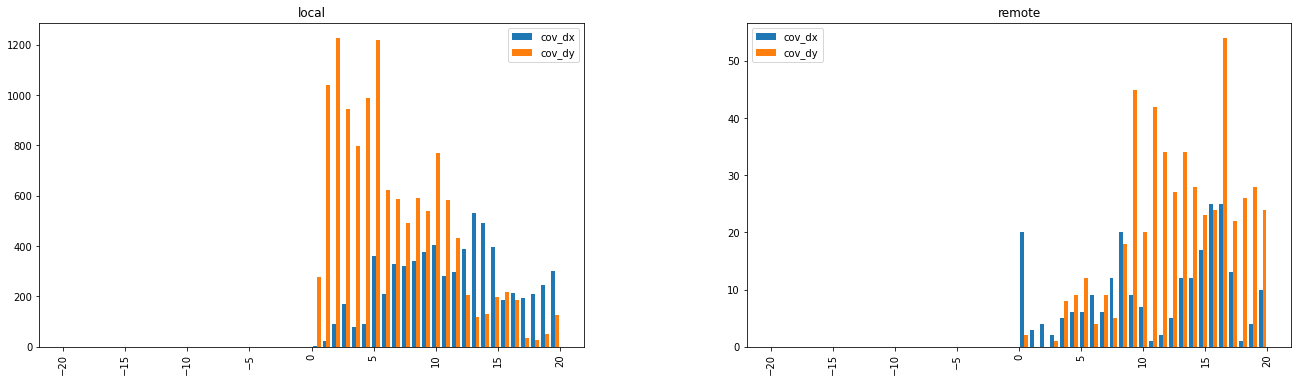

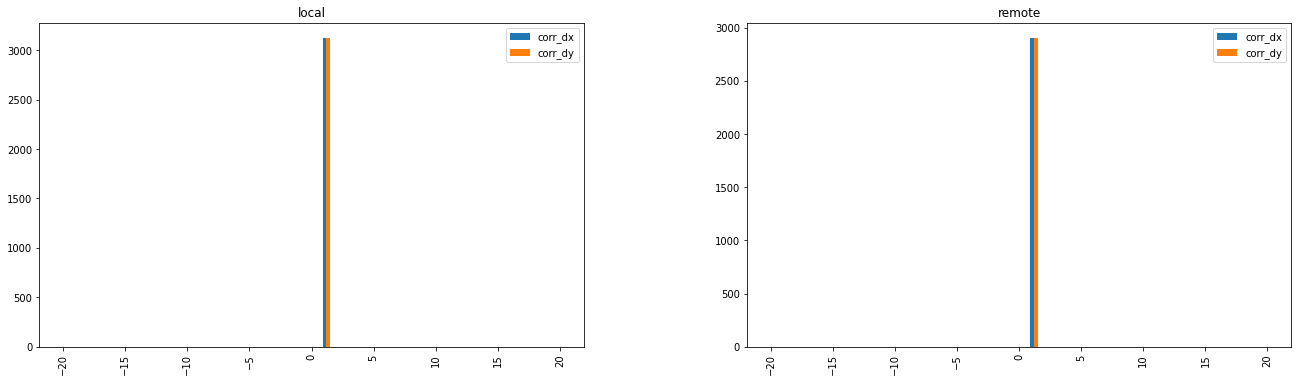

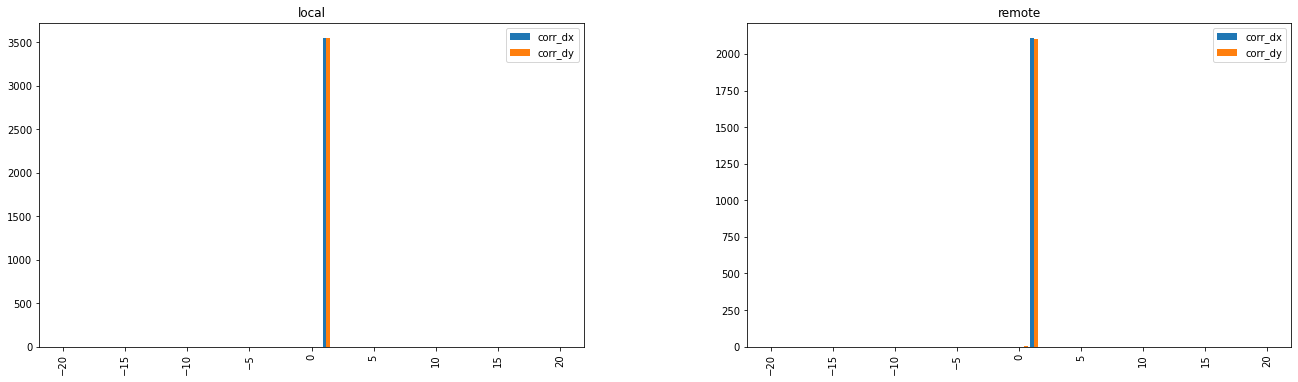

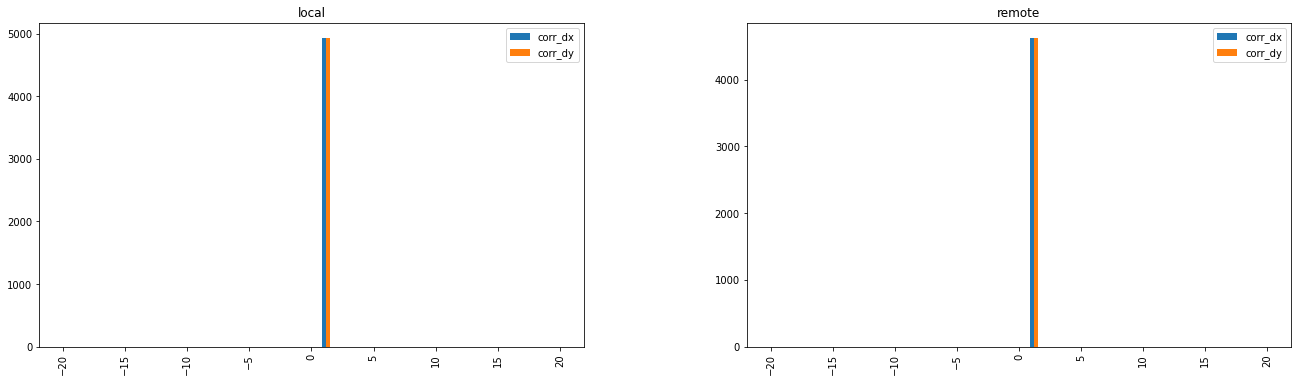

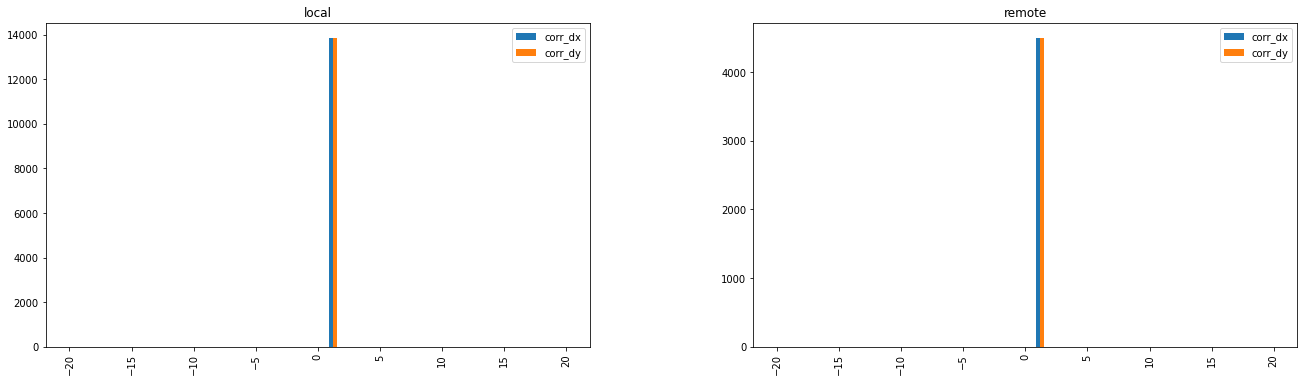

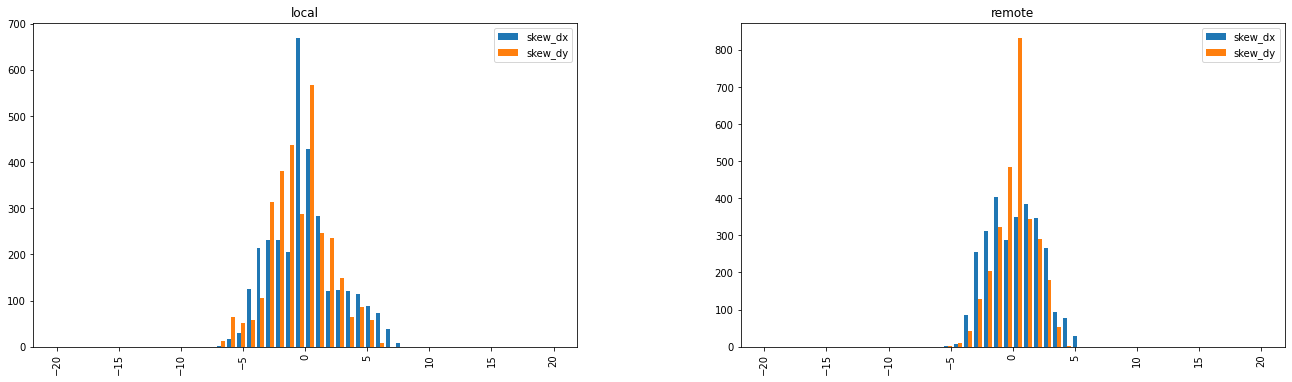

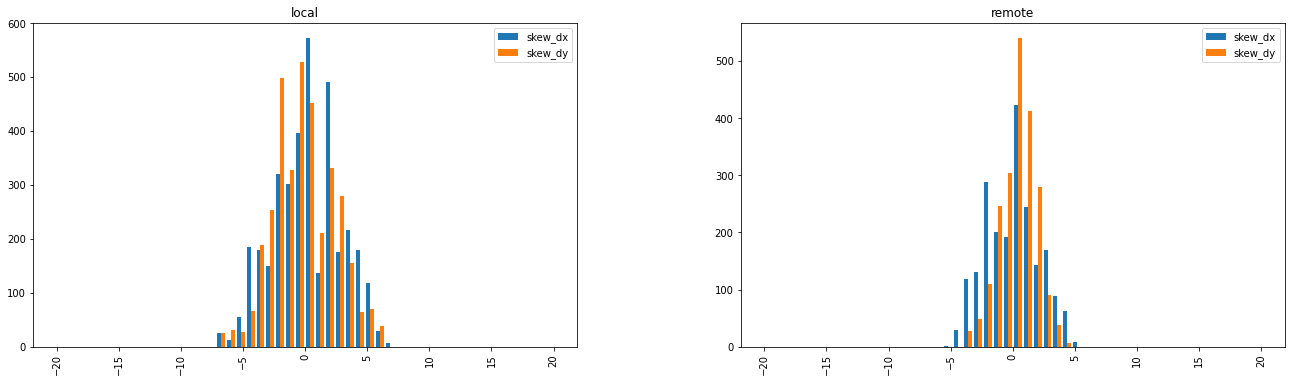

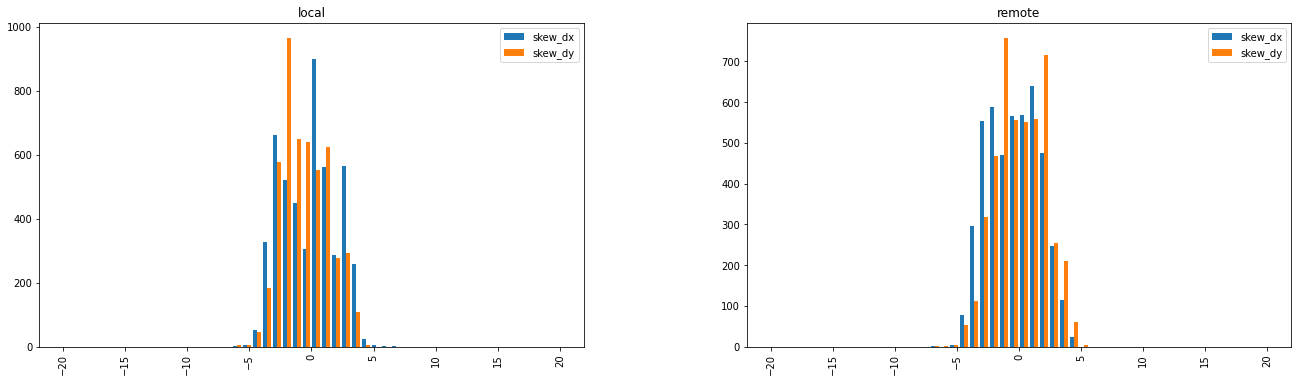

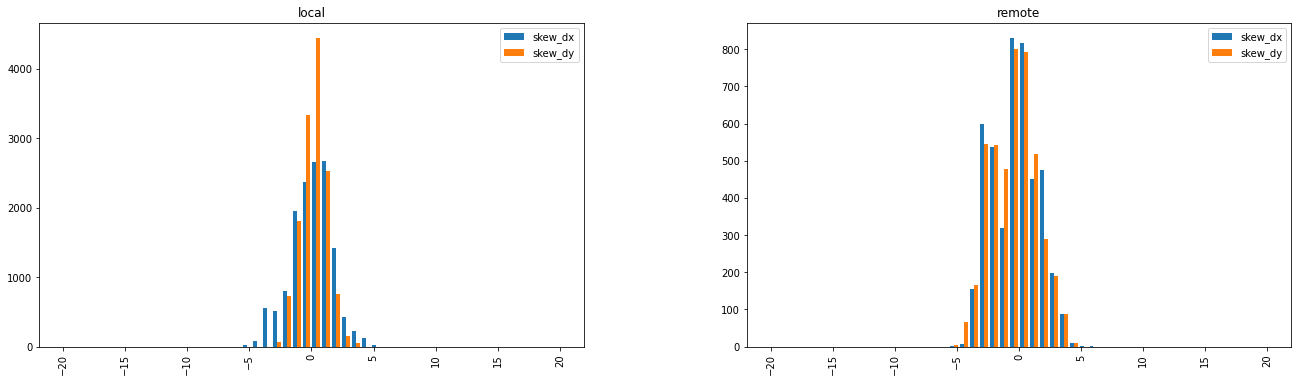

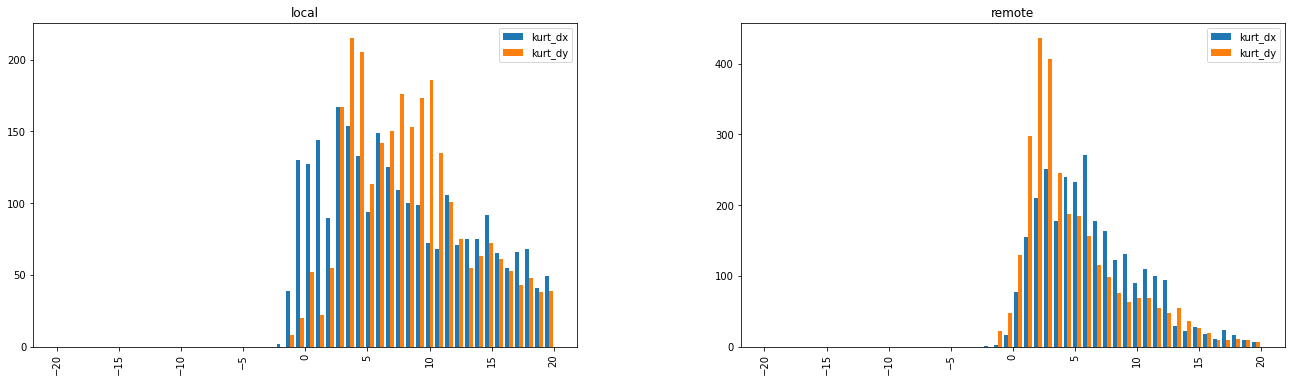

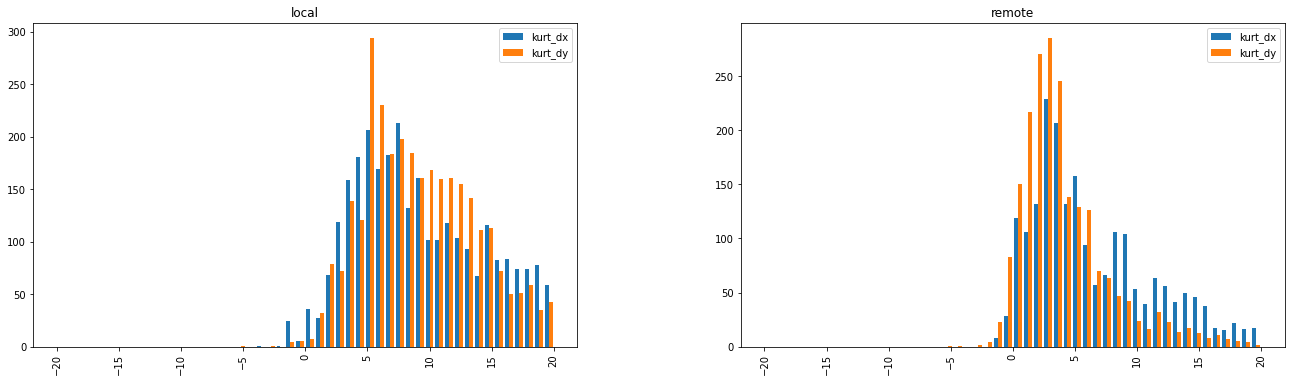

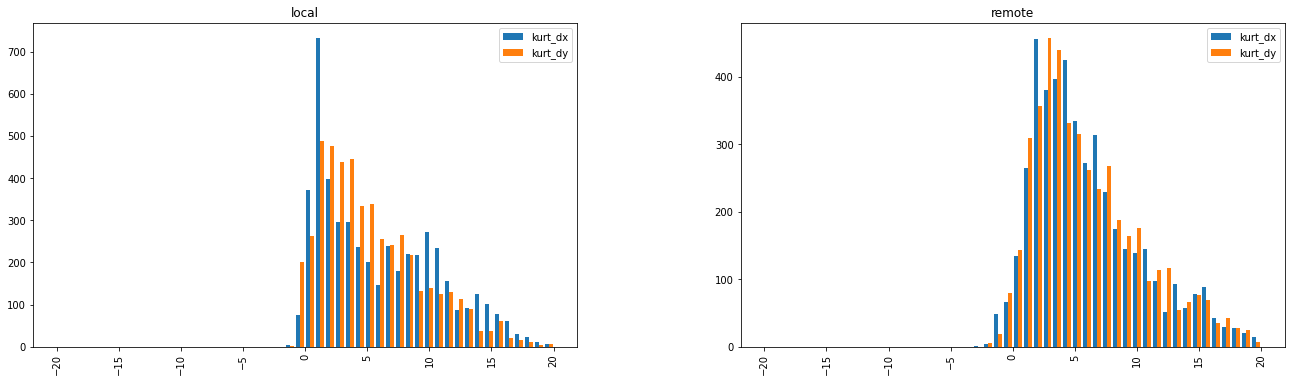

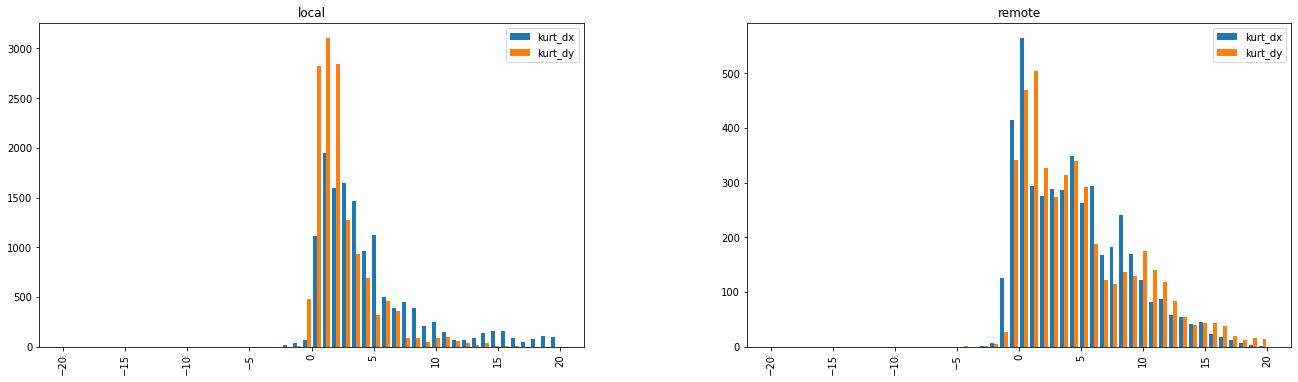

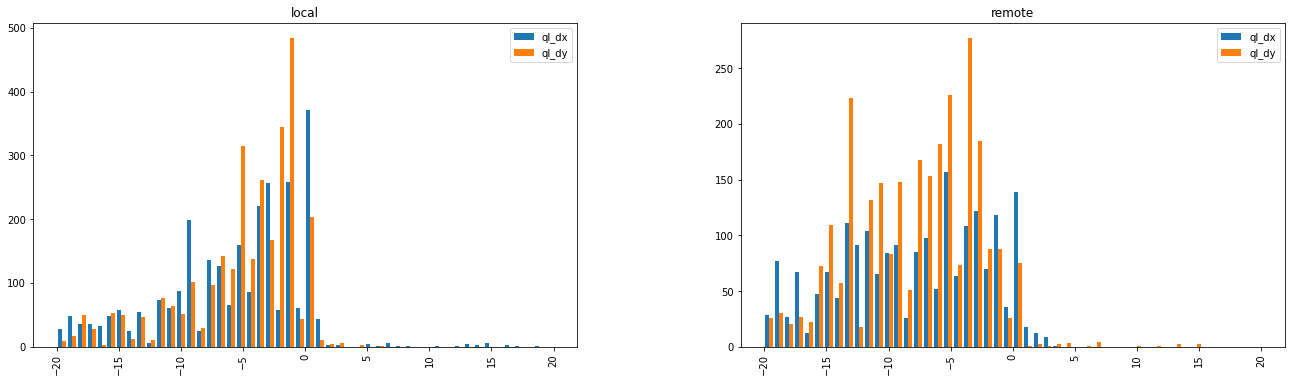

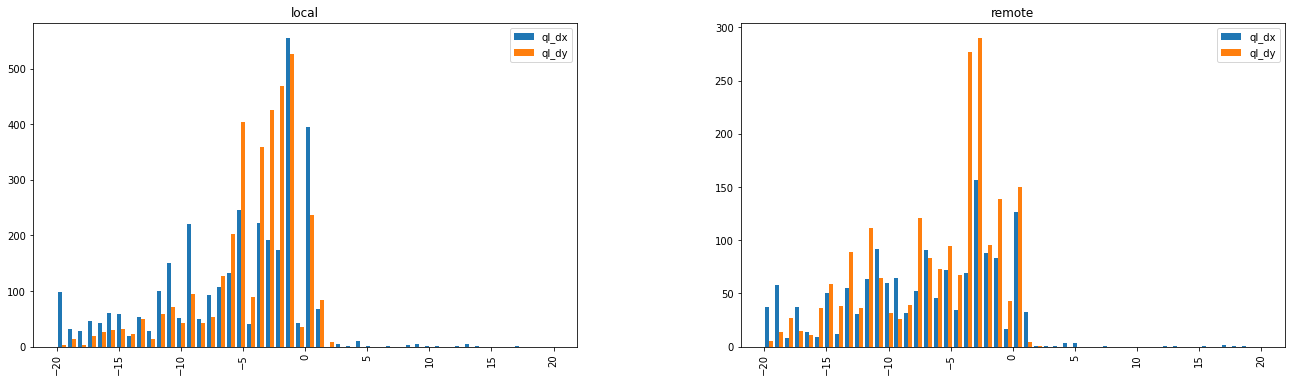

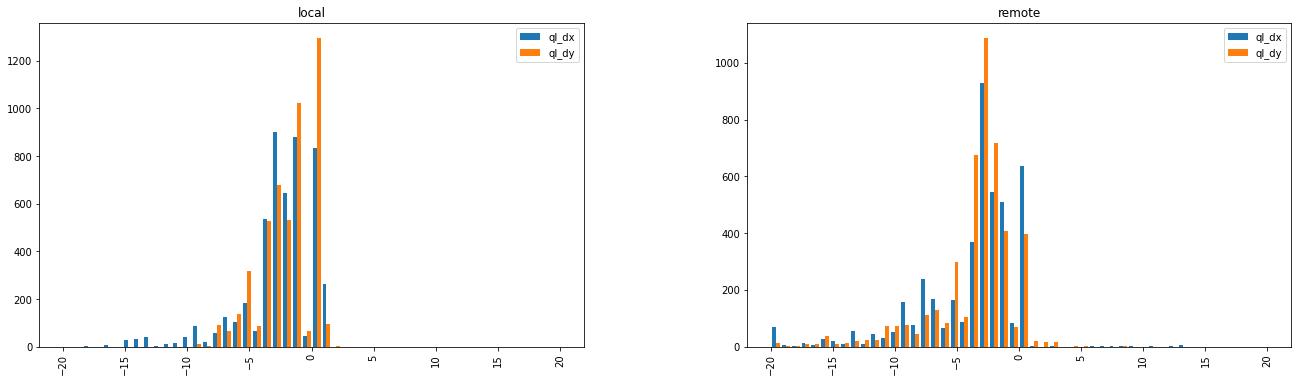

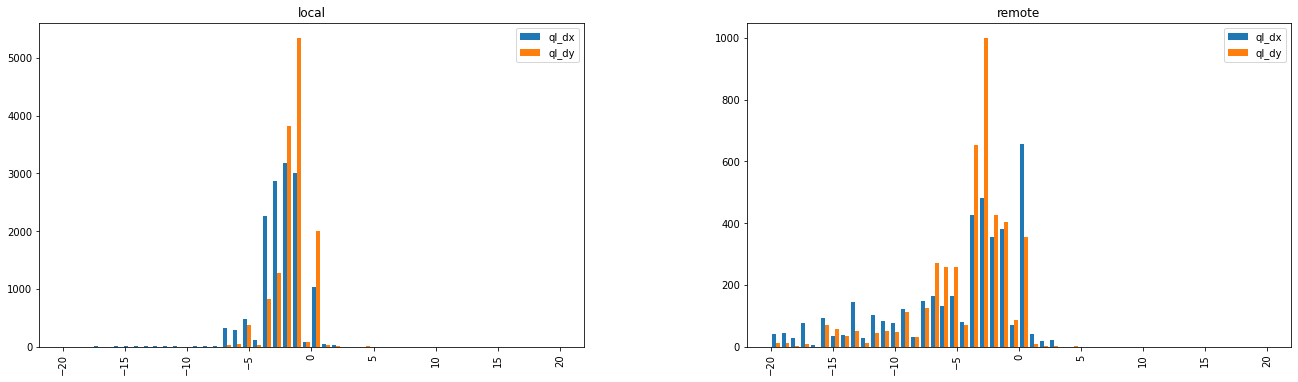

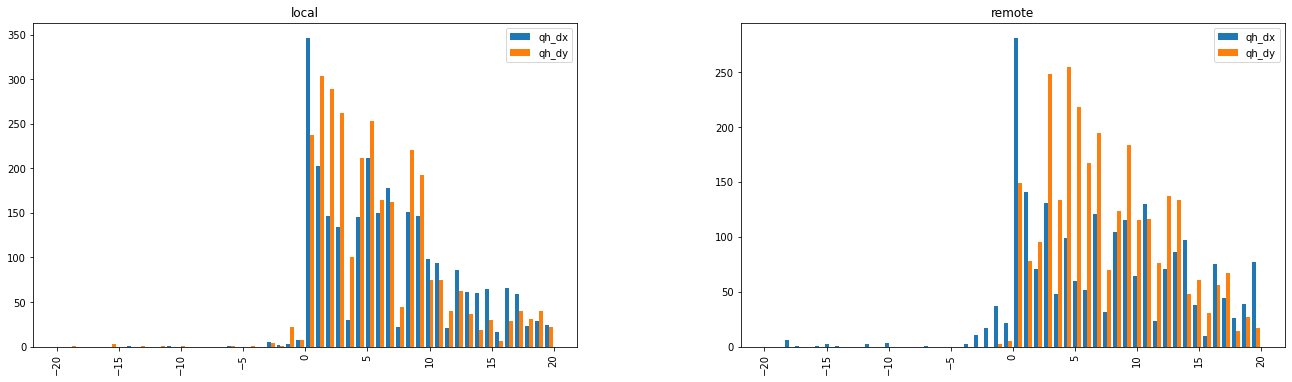

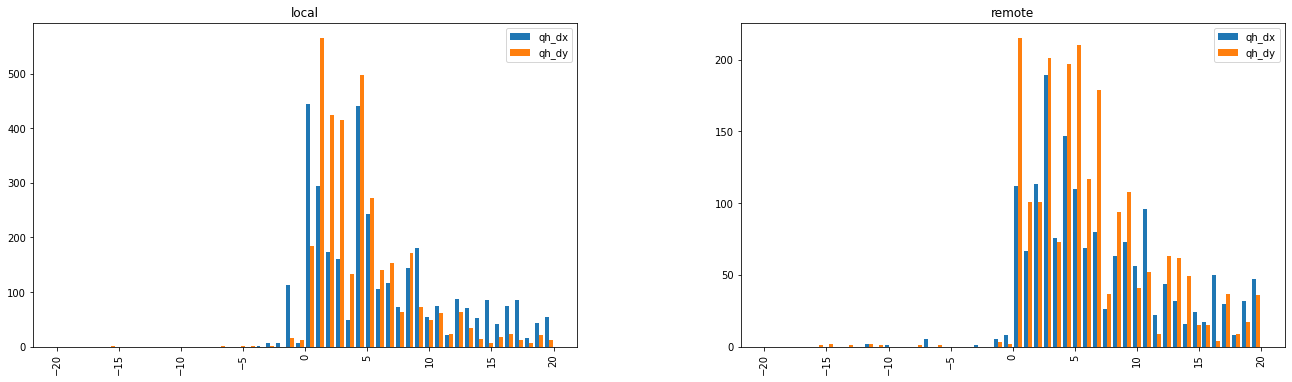

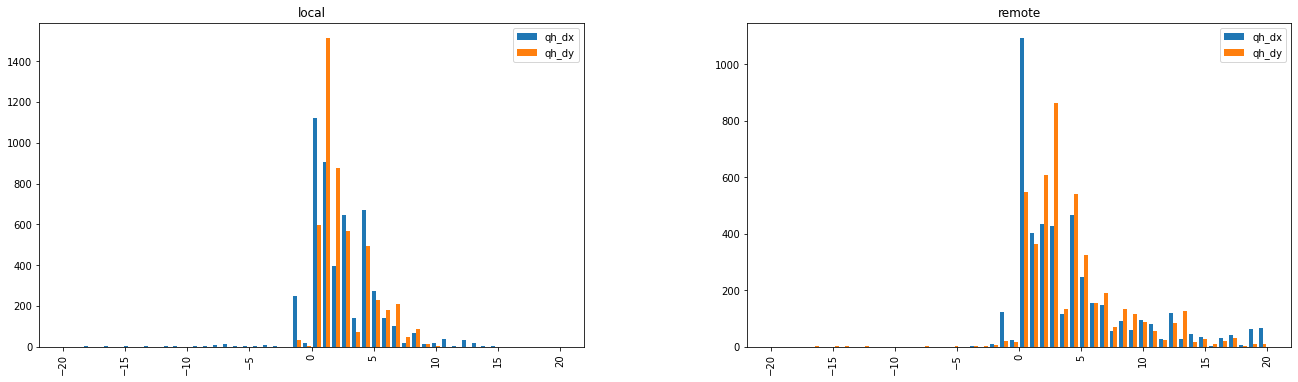

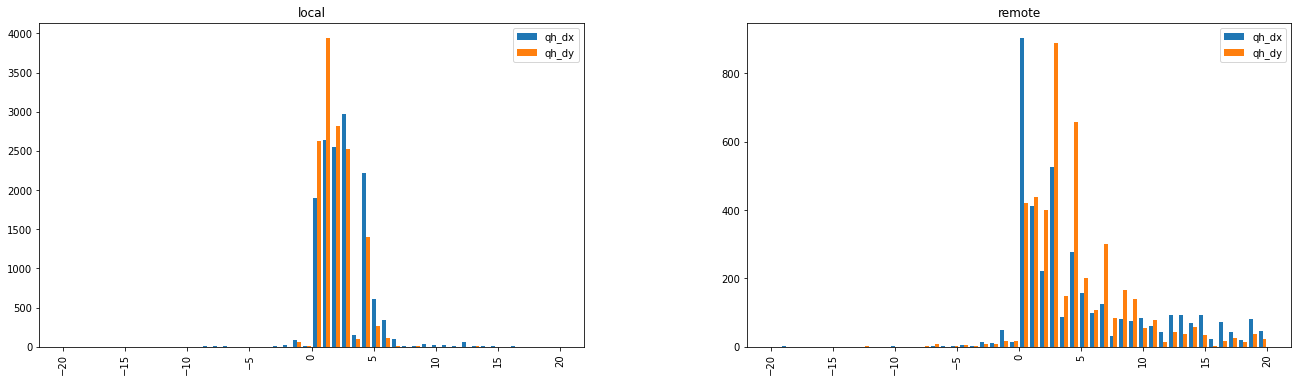

In [ ]:
 vd = [ 
        ['dx',        'dy',        'session', 'sid'],
        ['std_dx',    'std_dy',    'session', 'sid'],
        ['mean_dx',   'mean_dy',   'session', 'sid'],
        ['median_dx', 'median_dy', 'session', 'sid'],
        ['cov_dx',    'cov_dy',    'session', 'sid'],
        ['skew_dx',   'skew_dy',   'session', 'sid'] ,
        ['kurt_dx',   'kurt_dy',   'session', 'sid'], 
        ['ql_dx',     'ql_dy',     'session', 'sid'] ,
        ['qh_dx',     'qh_dy',     'session', 'sid'] 
      ]
for mask in vd :
  mdp[mask].groupby('sid').hist(layout=(1,10),figsize=(120,6),bins=50,by='session',legend=True,range=[-20,20])
  plt.show()


## Analiza częstości próbkowania

Sprawdzam ile danych pomiarowych przeciętnie mieści się w oknach czasowych np 5s, 10s, 30s, dla sesji remote i local

Poniżej znajdują się wykresy pokazujące ilość próbek pozycji myszy w oknie czasowym. Okno przesuwane jest w sposób ciągły.

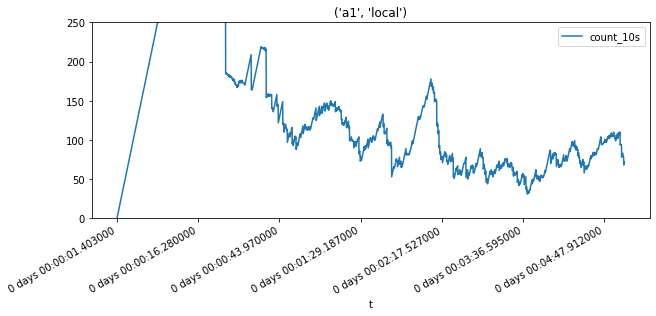

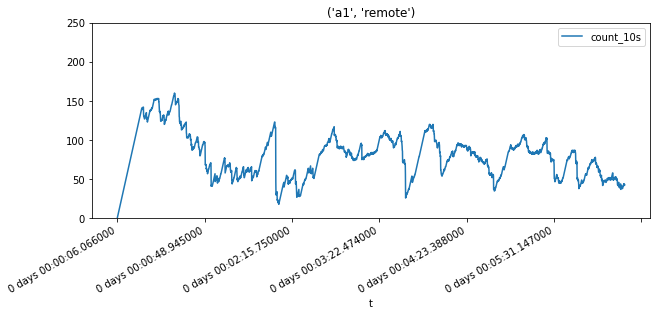

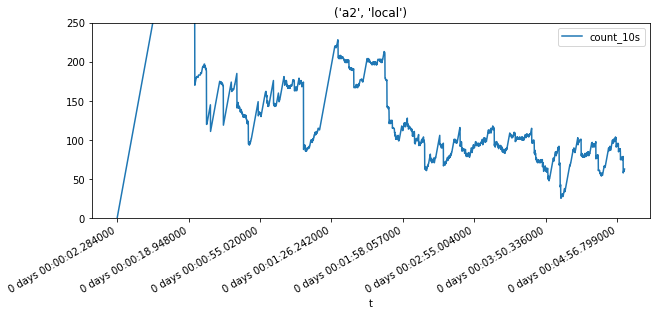

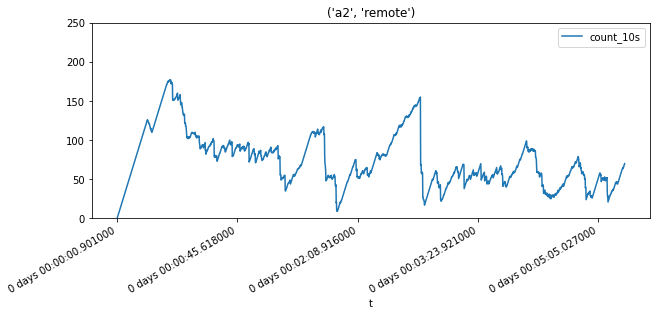

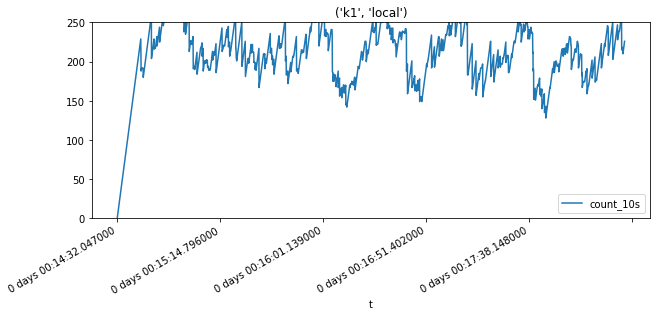

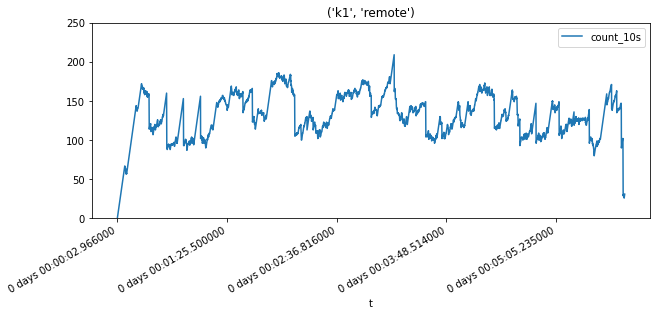

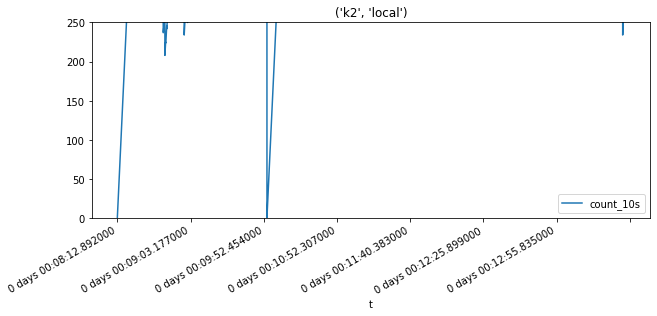

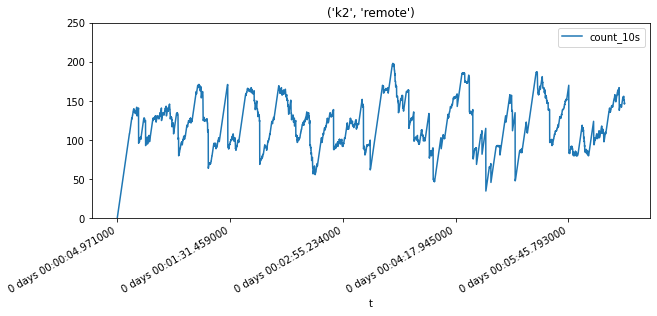

In [ ]:
for name, g in mdp.groupby(['sid','session']):
  g.plot(  kind='line', y='count_10s', title=str(name), ylim=(0,250),figsize=(10,4))

Ten wykres przedstawia sesje z linią trendu

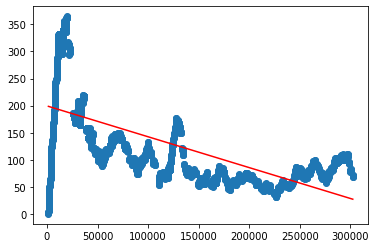

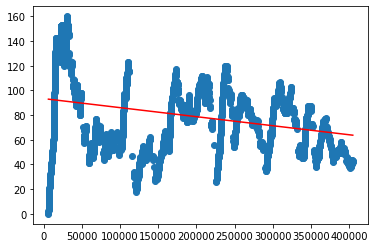

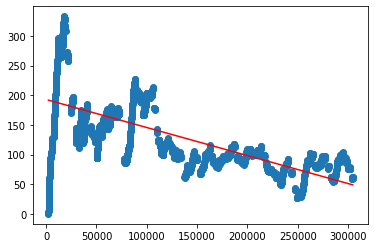

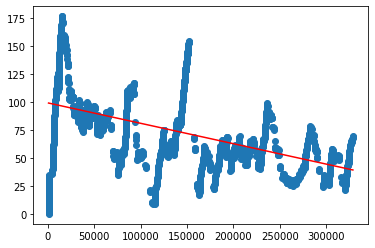

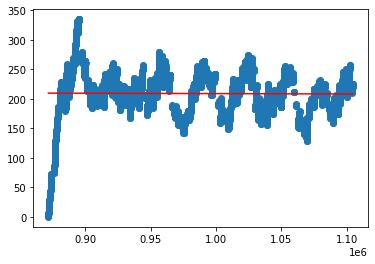

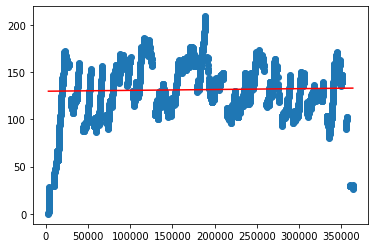

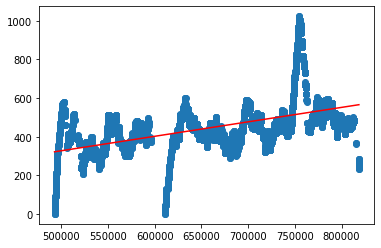

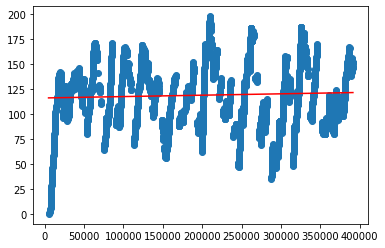

In [ ]:
for name, data in mdp.groupby(['sid','session']):
  # Regresion
  X = data.t_int.values.reshape(-1, 1)  # values converts it into a numpy array
  Y = data.count_10s.fillna(0).values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
  linear_regressor = LinearRegression()  # create object for the class
  linear_regressor.fit(X, Y)  # perform linear regression
  Y_pred = linear_regressor.predict(X)  # make predictions
  # Plot
  plt.scatter(X, Y)
  plt.plot(X, Y_pred, color='red')
  plt.show()



Ponizszy zestaw wykresów porównuje linie trendu tej samej sesji dla podłączenia zdalnego i lokalnego.

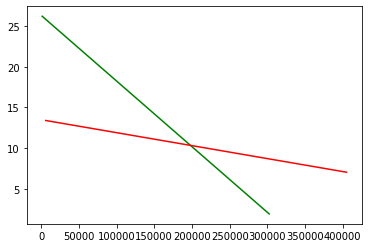

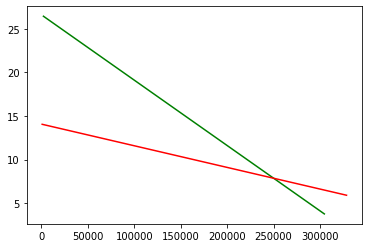

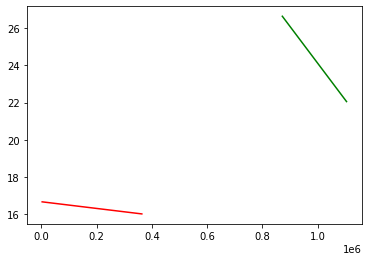

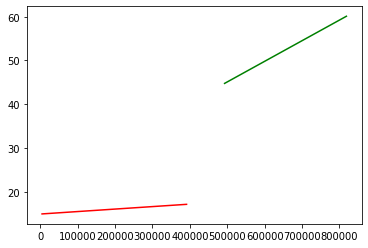

In [ ]:
def reg(data):
  X = data.t_int.values.reshape(-1, 1)  # values converts it into a numpy array
  Y = data.count_1s.fillna(0).values.reshape(-1, 1)  # -1 means that calculate the dimension of rows, but have 1 column
  linear_regressor = LinearRegression()  # create object for the class
  linear_regressor.fit(X, Y)  # perform linear regression
  Y_pred = linear_regressor.predict(X)  # make predictions
  return (X,Y,Y_pred)

for name, sidg in mdp.groupby(['sid']):
  data_l = sidg.groupby('session').get_group('local')
  data_r = sidg.groupby('session').get_group('remote')
  lreg = reg(data_l)
  rreg = reg(data_r)
  # Plot
  plt.plot(lreg[0], lreg[2], color='green')
  plt.plot(rreg[0], rreg[2], color='red')
  plt.show()

porównanie na jednym wykresie lini trendu sesji zdalnych i lokalnych

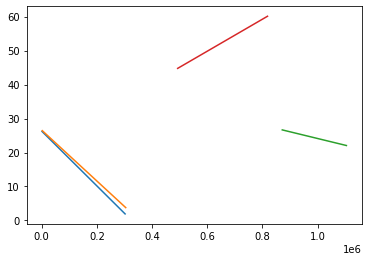

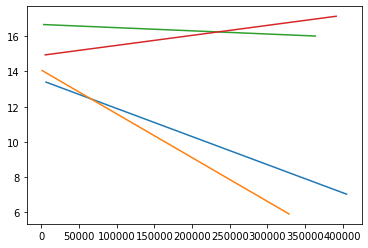

In [ ]:
for name, session_df in mdp.groupby(['session']):
  for name, sid_df in session_df.groupby(['sid']):
    r = reg(sid_df)
    plt.plot(r[0], r[2])
  plt.show()

## zbiorcze mini histograamy

In [ ]:
mdp.groupby(['sid','session']).hist(layout=(24,24),figsize=(30,30),bins=15)

## zależność od czasu

sid  session
a1   local      AxesSubplot(0.125,0.2;0.775x0.68)
     remote     AxesSubplot(0.125,0.2;0.775x0.68)
a2   local      AxesSubplot(0.125,0.2;0.775x0.68)
     remote     AxesSubplot(0.125,0.2;0.775x0.68)
k1   local      AxesSubplot(0.125,0.2;0.775x0.68)
     remote     AxesSubplot(0.125,0.2;0.775x0.68)
k2   local      AxesSubplot(0.125,0.2;0.775x0.68)
     remote     AxesSubplot(0.125,0.2;0.775x0.68)
dtype: object

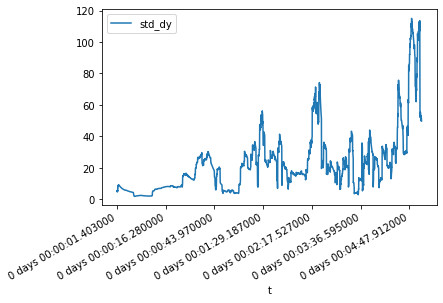

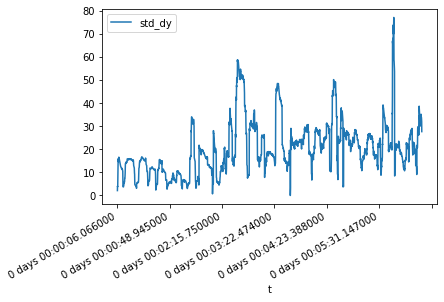

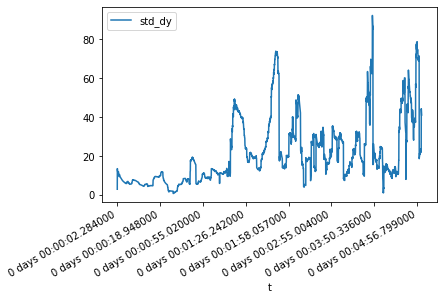

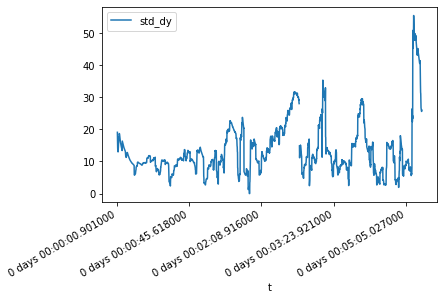

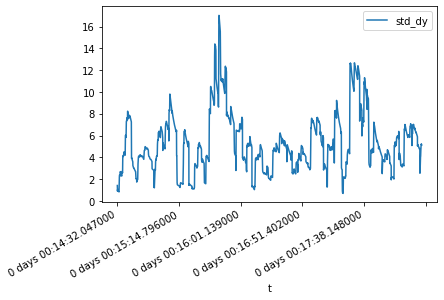

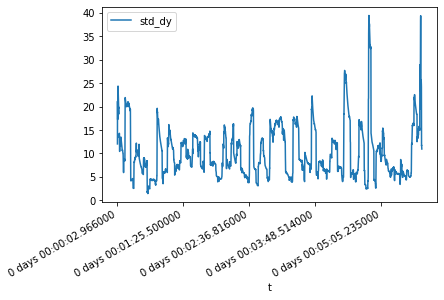

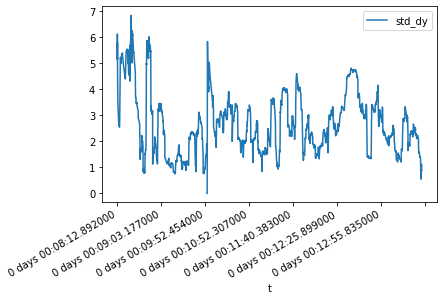

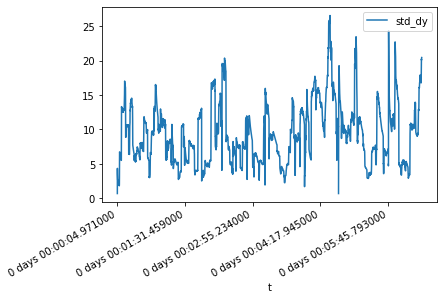

In [ ]:
mdp.groupby(['sid','session']).plot(kind="line",y="std_dy")

# Badanie zmiany krzywizny rozkładu


## Przygotowanie danych

In [ ]:
# MAX_L='2m' # Maxymalna długość sesji
WIN_L='60s'

# Dla kazdego file obciać długość do MAX_L
# def timecut():

def winLabel(data):
  groups = data.group(['session','sid'])
  groupIter = iter(groups)
  for in groupIter.next():




## wizualne porównanie rozkładów dx, dy w małych oknach

Dla próbki local i remote generuję N histogramów dla danych o długości M.
Celem tego kroku jest sprawdzenie czy na poziomie małej rozdzielczości danych np 5s, 15s, 20s widoczne są różnice na wykresach tak jak dla zbiorczego histogramu w sekcji **Wykresy**.


In [ ]:
mdp.ro